BERT, Classfication layer

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv('../datasets/data_train.csv')
test_data = pd.read_csv('../datasets/data_test.csv')
valid_data = pd.read_csv('../datasets/data_valid.csv')

In [2]:
def extract_texts_labels(data, label_encoder):
    texts = data['data'].values
    labels = data['label'].values
    encoded_labels = label_encoder.fit_transform(labels)
    return texts, encoded_labels

In [3]:
label_encoder = LabelEncoder()
train_texts, train_labels = extract_texts_labels(train_data, label_encoder)
test_texts, test_labels = extract_texts_labels(test_data, label_encoder)
valid_texts, valid_labels = extract_texts_labels(valid_data, label_encoder)


In [4]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-german-cased')

# Tokenize the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding='max_length', max_length=400)
valid_encodings = tokenizer(valid_texts.tolist(), truncation=True, padding='max_length', max_length=400)

In [5]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)

2024-07-26 12:02:24.607572: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-26 12:02:24.607596: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-26 12:02:24.607600: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-26 12:02:24.607612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-26 12:02:24.607621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
from transformers import TFBertForSequenceClassification

# Load the BERT model for sequence classification with the number of output labels
model = TFBertForSequenceClassification.from_pretrained('google-bert/bert-base-german-cased', num_labels=len(label_encoder.classes_))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['f1_macro']
)

In [ ]:
# Train the model
# f1_2 with 128
# f1 was with 64
# just bert with 32
model.fit(train_dataset.shuffle(1000).batch(64),
          validation_data=valid_dataset.batch(64),
          epochs=3)


Epoch 1/3


2024-07-22 12:05:41.915356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-07-22 12:05:42.836271: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


566/566 [==============================] - 3416s 6s/step - loss: 1.0570 - accuracy: 0.5791
Epoch 2/3
566/566 [==============================] - 6290s 11s/step - loss: 0.9397 - accuracy: 0.6364
Epoch 3/3
566/566 [==============================] - 4481s 8s/step - loss: 0.8772 - accuracy: 0.6660


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

283/283 [==============================] - 185s 644ms/step - loss: 1.0028 - accuracy: 0.6251
Loss: 1.0027962923049927
Accuracy: 0.6250552535057068


In [ ]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions.logits, axis=-1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

283/283 [==============================] - 189s 660ms/step


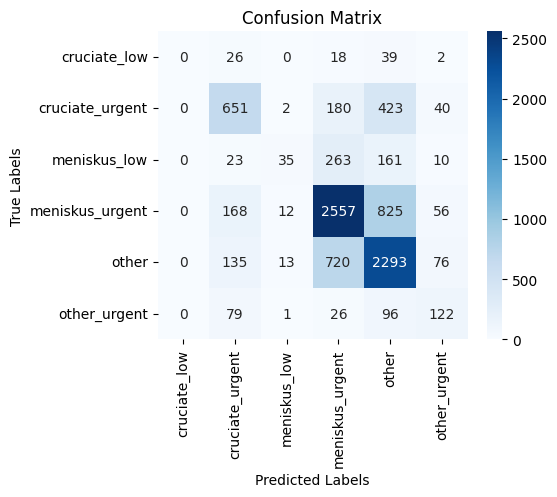

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                 precision    recall  f1-score   support

   cruciate_low       0.00      0.00      0.00        85
cruciate_urgent       0.60      0.50      0.55      1296
   meniskus_low       0.56      0.07      0.13       492
meniskus_urgent       0.68      0.71      0.69      3618
          other       0.60      0.71      0.65      3237
   other_urgent       0.40      0.38      0.39       324

       accuracy                           0.63      9052
      macro avg       0.47      0.39      0.40      9052
   weighted avg       0.62      0.63      0.61      9052



/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [ ]:
model.save_pretrained('german_bert_classify_model_f1_2')
tokenizer.save_pretrained('german_bert_classify_tokenizer_f1_2')

('german_bert_classify_tokenizer_f1_2/tokenizer_config.json',
 'german_bert_classify_tokenizer_f1_2/special_tokens_map.json',
 'german_bert_classify_tokenizer_f1_2/vocab.txt',
 'german_bert_classify_tokenizer_f1_2/added_tokens.json')

: 